In [151]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import xgboost as xgb
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids
from sklearn import ensemble, linear_model, preprocessing, neighbors, datasets
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier, StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_curve, auc, balanced_accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight


warnings.filterwarnings('ignore')

#We're dealing with a multiclass classification problem with 5 possible target classes

In [156]:
#loading the datasets
X_train = pd.read_csv('data/X_train.csv', engine='python')
X_test = pd.read_csv('data/X_test.csv', engine='python')
y_train = pd.read_csv('data/y_train.csv', engine='python')['rating']
y_test = pd.read_csv('data/y_test.csv', engine='python')['rating']

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

print("X_train info:", X_train.info())
print("X_train dtypes:", X_train.dtypes)


X_train shape: (51336, 7)
X_test shape: (12834, 7)
y_train shape: (51336,)
y_test shape: (12834,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51336 entries, 0 to 51335
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   number_reviews_scaled    51336 non-null  float64
 1   review_time_encoded      51336 non-null  int64  
 2   text_word_length_scaled  51336 non-null  float64
 3   Sentiment_VADER          51336 non-null  float64
 4   Sentiment_Blob           51336 non-null  float64
 5   bow_1920                 51336 non-null  int64  
 6   local_hour               51336 non-null  int64  
dtypes: float64(4), int64(3)
memory usage: 2.7 MB
X_train info: None
X_train dtypes: number_reviews_scaled      float64
review_time_encoded          int64
text_word_length_scaled    float64
Sentiment_VADER            float64
Sentiment_Blob             float64
bow_1920                     int64
local_hour   

,number_reviews_scaled,review_time_encoded,text_word_length_scaled,Sentiment_VADER,Sentiment_Blob,bow_1920,local_hour
0,-0.674019,1,-0.261191,0.0000,0.125000,0,7
1,0.494554,1,0.790268,0.2732,-0.087500,1,8
2,-0.089733,0,0.369684,0.5994,0.386667,0,9
3,-0.089733,1,-0.103473,0.9584,0.436111,0,6
4,2.247413,1,-0.208619,0.4019,-0.033333,0,11


In [139]:
model = MultinomialNB()
model.fit(X_train, y_train)

print(f'Accuracy : {round(model.score(X_test, y_test), 2)}')

cm = pd.crosstab(y_test, model.predict(X_test), rownames=['Real class'], colnames=['Predicted class'])
display(cm)

ValueError: Negative values in data passed to MultinomialNB (input X)

,number_reviews_scaled,review_time_encoded,text_word_length_scaled,Sentiment_VADER,Sentiment_Blob,bow_1920,local_hour,rating
0,2.247413,1,2.367457,0.7806,0.125556,0,-0.272568,1
1,-0.674019,1,-0.629202,-0.2263,-0.445833,0,1.366770,3
2,-0.089733,1,2.104592,-0.8011,-0.062143,0,-0.477486,1
3,-0.674019,1,1.158279,0.9698,0.283333,0,-0.887320,5
4,-0.674019,1,0.159392,-0.6324,0.057653,0,-0.682403,3


One: 20.0 %
Number of one ratings: 4313
Two: 20.0 %
Number of two ratings: 4313
Three: 20.0 %
Number of three ratings: 4313
Four: 20.0 %
Number of four ratings: 4313
Five: 20.0 %
Number of five ratings: 4313


,number_reviews_scaled,review_time_encoded,text_word_length_scaled,Sentiment_VADER,Sentiment_Blob,bow_1920,local_hour,rating
0,2.247413,1,2.367457,0.7806,0.125556,0,-0.254655,1
1,-0.674019,1,-0.629202,-0.2263,-0.445833,0,1.353202,3
2,-0.089733,1,2.104592,-0.8011,-0.062143,0,-0.455637,1
3,-0.674019,1,1.158279,0.9698,0.283333,0,-0.857601,5
4,-0.674019,1,0.159392,-0.6324,0.057653,0,-0.656619,3


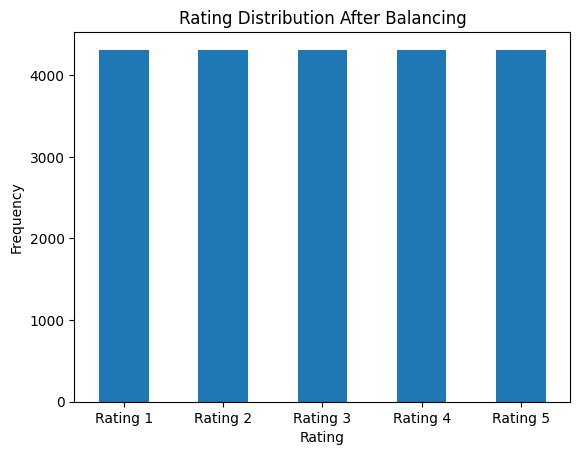

Rating 1: 20.00% Number of ratings: 4313
Rating 2: 20.00% Number of ratings: 4313
Rating 3: 20.00% Number of ratings: 4313
Rating 4: 20.00% Number of ratings: 4313
Rating 5: 20.00% Number of ratings: 4313


,number_reviews_scaled,review_time_encoded,text_word_length_scaled,Sentiment_VADER,Sentiment_Blob,bow_1920,local_hour
12058,2.247413,0,1.000560,-0.6604,0.075000,0,-1.058583
7303,-0.089733,0,-0.944640,0.0000,0.000000,0,1.755166
20704,-0.674019,0,-0.576629,-0.1531,0.000000,0,-0.455637
20528,2.247413,1,0.211965,0.3818,0.225000,0,-0.254655
5872,2.247413,1,-0.313764,-0.3612,0.416667,0,0.147309


(17252, 7)


In [119]:
#Anomaly detection

#Rejoin dataset
X_combined = pd.concat([X_train, X_test], axis=0)
y_combined = pd.concat([y_train, y_test], axis=0)
X_combined.reset_index(drop=True, inplace=True)
y_combined.reset_index(drop=True, inplace=True)
df_trustpilot = X_combined.copy()
df_trustpilot['rating'] = y_combined
df_trustpilot.reset_index(drop=True, inplace=True)
display(df_trustpilot.head())

#Display proportions
all = len(df_trustpilot)
one = df_trustpilot[df_trustpilot['rating'] == 1]
two = df_trustpilot[df_trustpilot['rating'] == 2]
three = df_trustpilot[df_trustpilot['rating'] == 3]
four = df_trustpilot[df_trustpilot['rating'] == 4]
five = df_trustpilot[df_trustpilot['rating'] == 5]
one_p = len(one)/all
two_p = len(two)/all
three_p = len(three)/all
four_p = len(four)/all
five_p = len(five)/all
print('One:',one_p*100,'%')
print("Number of one ratings:", len(one))
print('Two:',two_p*100,'%')
print("Number of two ratings:", len(two))
print('Three:',three_p*100,'%')
print("Number of three ratings:", len(three))
print('Four:',four_p*100,'%')
print("Number of four ratings:", len(four))
print('Five:',five_p*100,'%')
print("Number of five ratings:", len(five))

#Normalize the last feature
df_trustpilot['local_hour'] = StandardScaler().fit_transform(df_trustpilot['local_hour'].values.reshape(-1,1))
display(df_trustpilot.head())

#Rebalance the dataset
df_balanced = df_trustpilot.sample(frac=1, random_state=42)
rating_1 = df_balanced[df_balanced['rating'] == 1][:4313] 
rating_2 = df_balanced[df_balanced['rating'] == 2][:4313]      
rating_3 = df_balanced[df_balanced['rating'] == 3][:4313]  
rating_4 = df_balanced[df_balanced['rating'] == 4][:4313]  
rating_5 = df_balanced[df_balanced['rating'] == 5][:4313]  
df_balanced_final = pd.concat([rating_1, rating_2, rating_3, rating_4, rating_5])
df_balanced_final = df_balanced_final.sample(frac=1, random_state=42)
labels = ['Rating 1', 'Rating 2', 'Rating 3', 'Rating 4', 'Rating 5']
classes = pd.value_counts(df_balanced_final['rating'], sort=True)
classes.plot(kind='bar', rot=0)
plt.title("Rating Distribution After Balancing")
plt.xticks(range(5), labels)
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()
for rating in range(1, 6):
    count = len(df_balanced_final[df_balanced_final['rating'] == rating])
    percentage = (count / len(df_balanced_final)) * 100
    print(f"Rating {rating}: {percentage:.2f}% Number of ratings: {count}")

X = df_balanced_final.drop('rating', axis=1)
y = df_balanced_final['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)

display(X.head())
print(X_train.shape)

In [157]:
#Non-anomaly detection code
X_train = pd.read_csv('data/X_train.csv', engine='python')
X_test = pd.read_csv('data/X_test.csv', engine='python')
y_train = pd.read_csv('data/y_train.csv', engine='python')['rating']
y_test = pd.read_csv('data/y_test.csv', engine='python')['rating']

#Scale local_hour
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

#Base model - Logistic regression
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
custom_weights = {1: 2.0, 2: 7.0, 3: 5.0, 4: 5.0, 5: 1.0}
param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 50, 100, 500], 'class_weight': ['balanced', 'balanced_subsample'], 'solver': ['lbfgs', 'liblinear', 'saga'], 'max_iter': [1000, 2000, 3000, 4000]}
param_grid_lr['class_weight'].append(custom_weights)
grid_search_lr = GridSearchCV(LogisticRegression(random_state=25, max_iter=2000), param_grid_lr, cv=5, scoring='balanced_accuracy', n_jobs=-1)
grid_search_lr.fit(X_train, y_train)
best_lr = grid_search_lr.best_estimator_
print("Best Base Model parameters found:", grid_search_lr.best_params_)
print("Best Base Model cross-validation score:", grid_search_lr.best_score_)

model = LogisticRegression(**grid_search_lr.best_params_, random_state=25)
model.fit(X_train, y_train)
base_model_score = model.score(X_test, y_test)
y_pred = model.predict(X_test)
base_model_cr = classification_report(y_test, y_pred)
base_model_roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')
base_model_balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print("Accuracy Base Model: ", base_model_score * 100, "%")
print("Balanced Accuracy Base Model: ", base_model_balanced_accuracy * 100, "%")
print("ROC AUC Base Model: ", base_model_roc_auc * 100, "%")
print("Classification Report Base Model: ", "\n", base_model_cr)

#Bagging Classifier
param_grid_bc = {'n_estimators': [100, 200, 300], 'max_samples': [0.5, 0.6, 0.7], 'max_features': [0.5, 0.6, 0.7], 'bootstrap_features': [True, False]}
grid_search_bc = GridSearchCV(BaggingClassifier(estimator=LogisticRegression(**grid_search_lr.best_params_, random_state=25), bootstrap=True, n_jobs=-1, random_state=25),
    param_grid_bc, cv=5, scoring='balanced_accuracy', n_jobs=-1)
grid_search_bc.fit(X_train, y_train)
print("Best Bagging Classifier parameters:", grid_search_bc.best_params_)
print("Best Bagging Classifier score:", grid_search_bc.best_score_)

bc = BaggingClassifier(estimator=model, **grid_search_bc.best_params_, bootstrap=True, n_jobs=-1, random_state=25)
bc.fit(X_train, y_train)
score_bc = bc.score(X_test, y_test)
y_pred_bc = bc.predict(X_test)
cr_bc = classification_report(y_test, y_pred_bc)
balanced_accuracy_bc = balanced_accuracy_score(y_test, y_pred_bc)
roc_auc_bc = roc_auc_score(y_test, bc.predict_proba(X_test), multi_class='ovr')
print("Accuracy Bagging Classifier: ", score_bc * 100, "%")
print("Balanced Accuracy Bagging Classifier: ", balanced_accuracy_bc * 100, "%")
print("ROC AUC Bagging Classifier: ", roc_auc_bc * 100, "%")
print("Classification Report Bagging Classifier: ", "\n", cr_bc)

#Adaptive Boosting
param_grid_ac = {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.3, 0.5, 1.0], 'algorithm': ['SAMME', 'SAMME.R']}
grid_search_ac = GridSearchCV(AdaBoostClassifier(estimator=LogisticRegression(**grid_search_lr.best_params_, random_state=25),random_state=25),
    param_grid_ac, cv=5, scoring='balanced_accuracy', n_jobs=-1)
grid_search_ac.fit(X_train, y_train)
print("Best AdaBoost parameters:", grid_search_ac.best_params_)
print("Best AdaBoost score:", grid_search_ac.best_score_)

ac = AdaBoostClassifier(estimator=model, **grid_search_ac.best_params_, random_state=25)
ac.fit(X_train, y_train)
score_ac = ac.score(X_test, y_test)
y_pred_ac = ac.predict(X_test)
cr_ac = classification_report(y_test, y_pred_ac)
balanced_accuracy_ac = balanced_accuracy_score(y_test, y_pred_ac)
roc_auc_ac = roc_auc_score(y_test, ac.predict_proba(X_test), multi_class='ovr')
print("Accuracy Adaptive Boosting Classifier: ", score_ac * 100, "%")
print("Balanced Accuracy Adaptive Boosting Classifier: ", balanced_accuracy_ac * 100, "%")
print("ROC AUC Adaptive Boosting Classifier: ", roc_auc_ac * 100, "%")
print("Classification Report Adaptive Boosting Classifier: ", "\n", cr_ac)

#Gradient Boosting Classifier
param_grid_gb = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 4, 5], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'subsample': [0.8, 0.9, 1.0]}
grid_search_gb = GridSearchCV(GradientBoostingClassifier(random_state=25),
    param_grid_gb, cv=5, scoring='balanced_accuracy', n_jobs=-1)
grid_search_gb.fit(X_train, y_train)
print("Best Gradient Boosting parameters:", grid_search_gb.best_params_)
print("Best Gradient Boosting score:", grid_search_gb.best_score_)

gb = GradientBoostingClassifier(**grid_search_gb.best_params_, random_state=25)
gb.fit(X_train, y_train)
score_gb = gb.score(X_test, y_test)
y_pred_gb = gb.predict(X_test)
cr_gb = classification_report(y_test, y_pred_gb)
balanced_accuracy_gb = balanced_accuracy_score(y_test, y_pred_gb)
roc_auc_gb = roc_auc_score(y_test, gb.predict_proba(X_test), multi_class='ovr')
print("Accuracy Gradient Boosting Classifier: ", score_gb * 100, "%")
print("Balanced Accuracy Gradient Boosting Classifier: ", balanced_accuracy_gb * 100, "%")
print("ROC AUC Gradient Boosting Classifier: ", roc_auc_gb * 100, "%")
print("Classification Report Gradient Boosting Classifier: ", "\n", cr_gb)


Best Base Model parameters found: {'C': 1, 'class_weight': 'balanced', 'max_iter': 2000, 'solver': 'saga'}
Best Base Model cross-validation score: 0.4244450140361796
Accuracy Base Model:  57.44117188717469 %
Balanced Accuracy Base Model:  43.319068141817155 %
ROC AUC Base Model:  79.25080068796132 %
Classification Report Base Model:  
               precision    recall  f1-score   support

           1       0.74      0.62      0.68      3188
           2       0.18      0.23      0.20       863
           3       0.23      0.30      0.26      1254
           4       0.17      0.30      0.22      1257
           5       0.85      0.71      0.77      6272

    accuracy                           0.57     12834
   macro avg       0.43      0.43      0.43     12834
weighted avg       0.65      0.57      0.61     12834



KeyboardInterrupt: 

In [125]:
# Current best model
# XGBoostClassifier with GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 300],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1],
    'scale_pos_weight': [1, 3, 5],
    'class_weight': ['balanced']
}
# Create and fit model with GridSearchCV
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob', 
    num_class=5,
    subsample=0.8,  # add these as fixed parameters instead
    colsample_bytree=0.8
)
grid_search = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid, 
    cv=5, 
    scoring='f1_weighted',  # better for imbalanced data
    verbose=2  # increased verbosity to see progress
)

# Fit with 0-based labels
grid_search.fit(X_train, y_train - 1)

# Print best parameters
print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Now use the best parameters with the original XGBoost implementation
best_params = grid_search.best_params_

# Adjust labels to be 0-based
y_train_0based = y_train - 1
y_test_0based = y_test - 1

# Create DMatrix objects with 0-based labels
train = xgb.DMatrix(X_train, y_train_0based)
test = xgb.DMatrix(X_test, y_test_0based)

# Set parameters using GridSearchCV results
params = {'booster': 'gbtree',
    'objective': 'multi:softprob',
    'num_class': 5,
    'learning_rate': best_params['learning_rate'],
    'max_depth': best_params['max_depth']}

# Train model
model = xgb.train(params,  dtrain=train, 
    num_boost_round=best_params['n_estimators'],
    early_stopping_rounds=15, 
    evals=[(train, 'train'), (test, 'eval')])

# Get predictions and convert back to 1-based
preds_prob = model.predict(test)
preds = np.argmax(preds_prob, axis=1) + 1  

# Print metrics
print("\nFinal Model Performance:")
print("Confusion Matrix - XGBoost: \n", confusion_matrix(y_test, preds))
print("\nClassification Report - XGBoost: \n", classification_report(y_test, preds))
print("\nROC AUC - XGBoost: ", roc_auc_score(
    pd.get_dummies(y_test), 
    preds_prob, 
    multi_class='ovr'))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END class_weight=balanced, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, scale_pos_weight=1; total time=   0.7s
[CV] END class_weight=balanced, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, scale_pos_weight=1; total time=   0.7s
[CV] END class_weight=balanced, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, scale_pos_weight=1; total time=   0.7s
[CV] END class_weight=balanced, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, scale_pos_weight=1; total time=   0.7s
[CV] END class_weight=balanced, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, scale_pos_weight=1; total time=   0.7s
[CV] END class_weight=balanced, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, scale_pos_weight=3; total time=   0.7s
[CV] END class_weight=balanced

In [132]:
#Ensemble method
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

# Initialize base classifiers
clf1 = KNeighborsClassifier(n_neighbors=3)
clf2 = RandomForestClassifier(random_state=123)
clf3 = LogisticRegression(max_iter=1000)  # Assuming this is your 'model'

# Voting Classifier
vclf = VotingClassifier(
    estimators=[('knn', clf1), ('rf', clf2), ('lr', clf3)],
    voting='hard'
)
vclf.fit(X_train, y_train)
print("Voting Classifier Score:", vclf.score(X_test, y_test))

# Cross validation for each classifier
classifiers = [
    (clf1, 'KNN'),
    (clf2, 'Random Forest'),
    (clf3, 'Logistic Regression'),
    (vclf, 'Voting Classifier')
]

for clf, label in classifiers:
    scores = cross_validate(
        clf, 
        X_train, 
        y_train, 
        cv=5, 
        scoring=['accuracy', 'f1_weighted']
    )
    print(f"\n[{label}]:")
    print(f"Accuracy: {scores['test_accuracy'].mean():.2f} (+/- {scores['test_accuracy'].std():.2f})")
    print(f"F1 score: {scores['test_f1_weighted'].mean():.2f} (+/- {scores['test_f1_weighted'].std():.2f})")

# Stacking Classifier
sclf = StackingClassifier(
    estimators=[('knn', clf1), ('rf', clf2), ('lr', clf3)],
    final_estimator=LogisticRegression(),
    cv=5
)

# Cross validation for Stacking
scores = cross_validate(
    sclf, 
    X_train, 
    y_train, 
    cv=5, 
    scoring=['accuracy', 'f1_weighted']
)
print("\n[Stacking Classifier]:")
print(f"Accuracy: {scores['test_accuracy'].mean():.2f} (+/- {scores['test_accuracy'].std():.2f})")
print(f"F1 score: {scores['test_f1_weighted'].mean():.2f} (+/- {scores['test_f1_weighted'].std():.2f})")

# Final fit and score
sclf.fit(X_train, y_train)
print("Stacking Classifier Score:", sclf.score(X_test, y_test))

Voting Classifier Score: 0.39554834222119173

[KNN]:
Accuracy: 0.35 (+/- 0.00)
F1 score: 0.34 (+/- 0.00)

[Random Forest]:
Accuracy: 0.41 (+/- 0.00)
F1 score: 0.40 (+/- 0.00)

[Logistic Regression]:
Accuracy: 0.43 (+/- 0.00)
F1 score: 0.41 (+/- 0.01)

[Voting Classifier]:
Accuracy: 0.40 (+/- 0.00)
F1 score: 0.38 (+/- 0.00)

[Stacking Classifier]:
Accuracy: 0.43 (+/- 0.01)
F1 score: 0.43 (+/- 0.01)
Stacking Classifier Score: 0.4266172038024577


In [127]:
#Base model
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

#Random Oversampling
rOs = RandomOverSampler()
X_ro, y_ro = rOs.fit_resample(X_train, y_train)
print(dict(pd.Series(y_ro).value_counts()))

model.fit(X_ro, y_ro)
y_pred = model.predict(X_test)
print(pd.crosstab(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

{5: np.int64(3478), 3: np.int64(3478), 4: np.int64(3478), 1: np.int64(3478), 2: np.int64(3478)}
col_0     1    2    3    4    5
rating                         
1       525  121  109   65   35
2       241  193  215  128   58
3       134  178  253  163  124
4        67   86  171  260  310
5        19   31   61  151  615
                   pre       rec       spe        f1       geo       iba       sup

          1       0.53      0.61      0.87      0.57      0.73      0.52       855
          2       0.32      0.23      0.88      0.27      0.45      0.19       835
          3       0.31      0.30      0.84      0.30      0.50      0.24       852
          4       0.34      0.29      0.85      0.31      0.50      0.23       894
          5       0.54      0.70      0.85      0.61      0.77      0.59       877

avg / total       0.41      0.43      0.86      0.41      0.59      0.35      4313



In [128]:
from imblearn.combine import SMOTETomek
#Base model
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

#SMOTE
smt = SMOTETomek()
X_resampled, y_resampled = smt.fit_resample(X_train, y_train)
print(dict(pd.Series(y_resampled).value_counts()))

model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)
print(pd.crosstab(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

{5: np.int64(2569), 1: np.int64(2370), 3: np.int64(2187), 4: np.int64(2165), 2: np.int64(2161)}
col_0     1    2    3    4    5
rating                         
1       527  114  119   53   42
2       251  177  224  117   66
3       139  156  273  149  135
4        68   84  180  231  331
5        20   29   65  141  622
                   pre       rec       spe        f1       geo       iba       sup

          1       0.52      0.62      0.86      0.57      0.73      0.52       855
          2       0.32      0.21      0.89      0.25      0.43      0.18       835
          3       0.32      0.32      0.83      0.32      0.52      0.25       852
          4       0.33      0.26      0.87      0.29      0.47      0.21       894
          5       0.52      0.71      0.83      0.60      0.77      0.58       877

avg / total       0.40      0.42      0.86      0.41      0.58      0.35      4313



In [129]:
#Base model
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

#SMOTE
smo = SMOTE()
X_sm, y_sm = smo.fit_resample(X_train, y_train)
print(dict(pd.Series(y_sm).value_counts()))

model.fit(X_sm, y_sm)
y_pred = model.predict(X_test)
print(pd.crosstab(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

{5: np.int64(3478), 3: np.int64(3478), 4: np.int64(3478), 1: np.int64(3478), 2: np.int64(3478)}
col_0     1    2    3    4    5
rating                         
1       523  120  112   64   36
2       241  194  210  132   58
3       134  175  255  166  122
4        67   88  169  264  306
5        18   32   62  151  614
                   pre       rec       spe        f1       geo       iba       sup

          1       0.53      0.61      0.87      0.57      0.73      0.52       855
          2       0.32      0.23      0.88      0.27      0.45      0.19       835
          3       0.32      0.30      0.84      0.31      0.50      0.24       852
          4       0.34      0.30      0.85      0.32      0.50      0.24       894
          5       0.54      0.70      0.85      0.61      0.77      0.58       877

avg / total       0.41      0.43      0.86      0.42      0.59      0.35      4313



In [130]:
#Base model
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

#Random Undersampling
rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train, y_train)
print(dict(pd.Series(y_ru).value_counts()))

model.fit(X_ru, y_ru)
y_pred = model.predict(X_test)
print(pd.crosstab(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

{1: np.int64(3419), 2: np.int64(3419), 3: np.int64(3419), 4: np.int64(3419), 5: np.int64(3419)}
col_0     1    2    3    4    5
rating                         
1       524  120  110   65   36
2       241  195  214  127   58
3       133  178  253  164  124
4        69   87  169  258  311
5        19   31   61  152  614
                   pre       rec       spe        f1       geo       iba       sup

          1       0.53      0.61      0.87      0.57      0.73      0.52       855
          2       0.32      0.23      0.88      0.27      0.45      0.19       835
          3       0.31      0.30      0.84      0.31      0.50      0.24       852
          4       0.34      0.29      0.85      0.31      0.50      0.23       894
          5       0.54      0.70      0.85      0.61      0.77      0.58       877

avg / total       0.41      0.43      0.86      0.41      0.59      0.35      4313



In [131]:
#Base model
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

#ClusterCentroids
cc = ClusterCentroids()
X_cc, y_cc = cc.fit_resample(X_train, y_train)
print(dict(pd.Series(y_cc).value_counts()))

model.fit(X_cc, y_cc)
y_pred = model.predict(X_test)
print(pd.crosstab(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

{1: np.int64(3419), 2: np.int64(3419), 3: np.int64(3419), 4: np.int64(3419), 5: np.int64(3419)}
col_0     1    2    3    4    5
rating                         
1       525  116  116   62   36
2       242  190  215  130   58
3       135  169  258  167  123
4        68   84  173  260  309
5        18   30   63  151  615
                   pre       rec       spe        f1       geo       iba       sup

          1       0.53      0.61      0.87      0.57      0.73      0.52       855
          2       0.32      0.23      0.89      0.27      0.45      0.19       835
          3       0.31      0.30      0.84      0.31      0.50      0.24       852
          4       0.34      0.29      0.85      0.31      0.50      0.23       894
          5       0.54      0.70      0.85      0.61      0.77      0.59       877

avg / total       0.41      0.43      0.86      0.41      0.59      0.35      4313

